<a href="https://colab.research.google.com/github/ReeganCodemaster/Covid-19-face-mask-detector/blob/main/Train_Face_Mask_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import shutil

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Fetching Our Data
We are using the Dataset provided by [prajnasb](https://github.com/prajnasb/observations)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
DATAPATH = '/content/drive/My Drive/Face Mask/data/'
MASKPATH = '/content/drive/My Drive/Face Mask/data/with_mask/'
NOMASKPATH = '/content/drive/My Drive/Face Mask/data/without_mask/'
TESTPATH = '/content/drive/My Drive/Face Mask/testdata'

# Visualizing our data

In [22]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

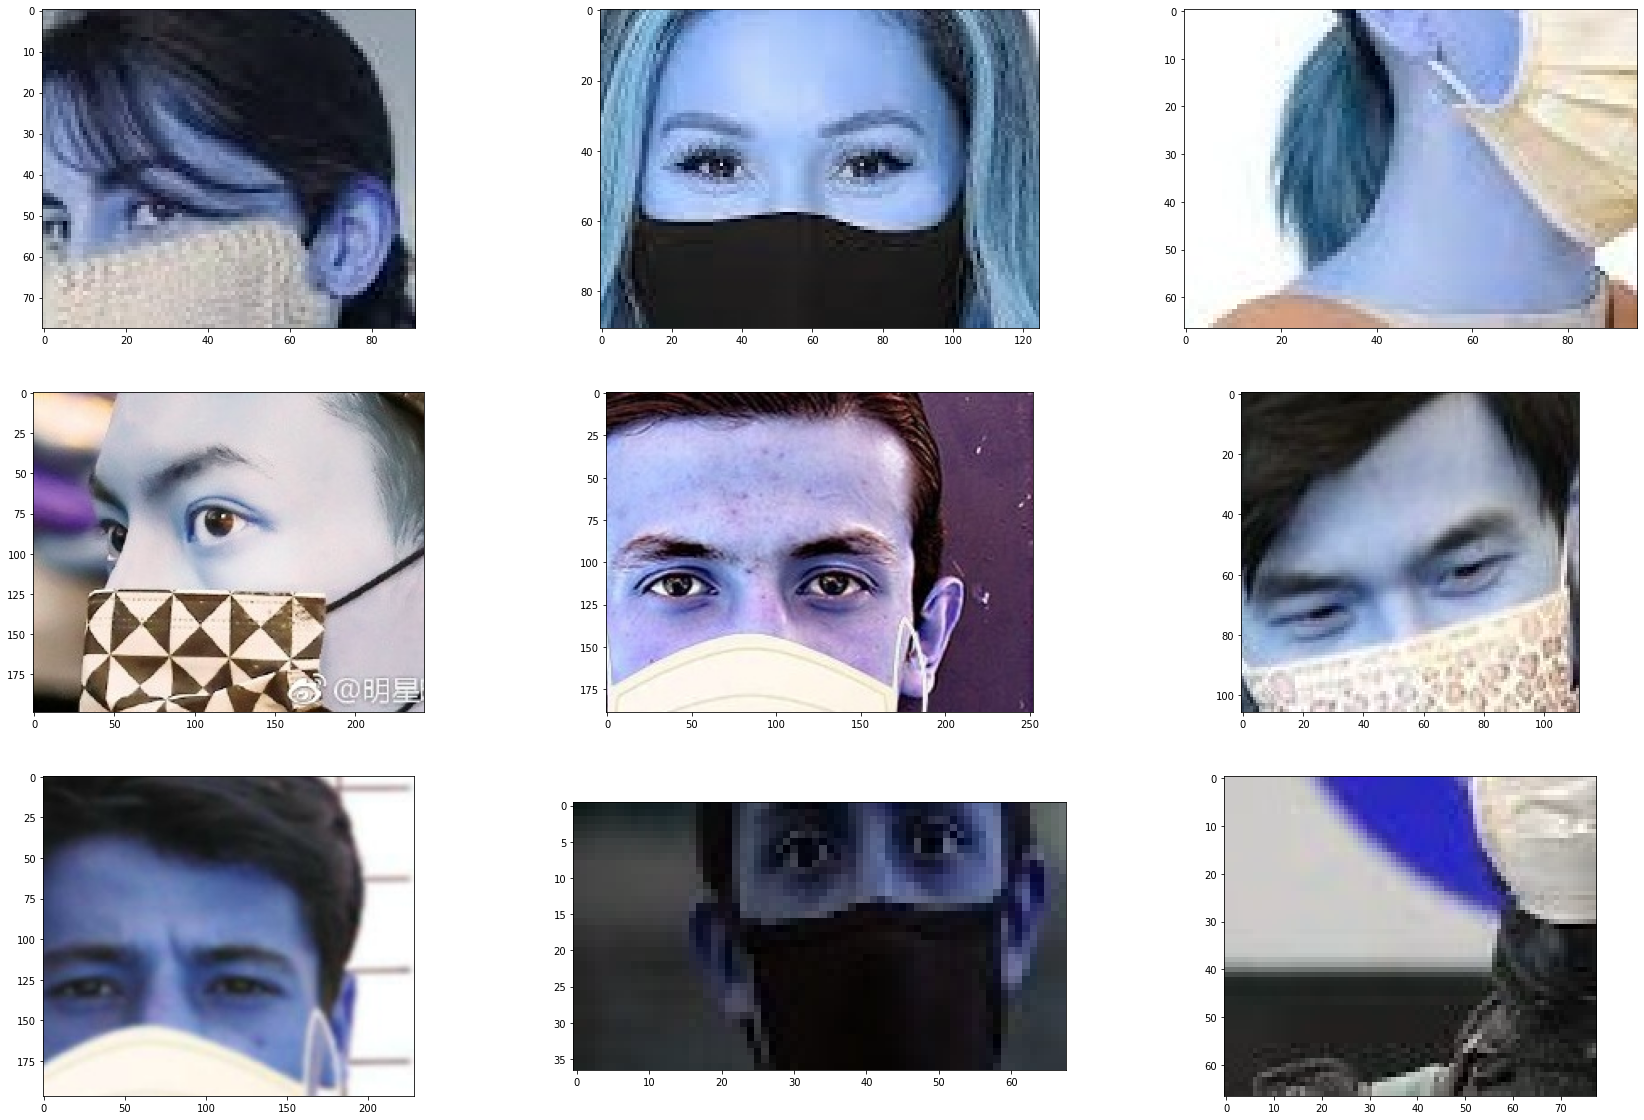

In [23]:
view(MASKPATH)

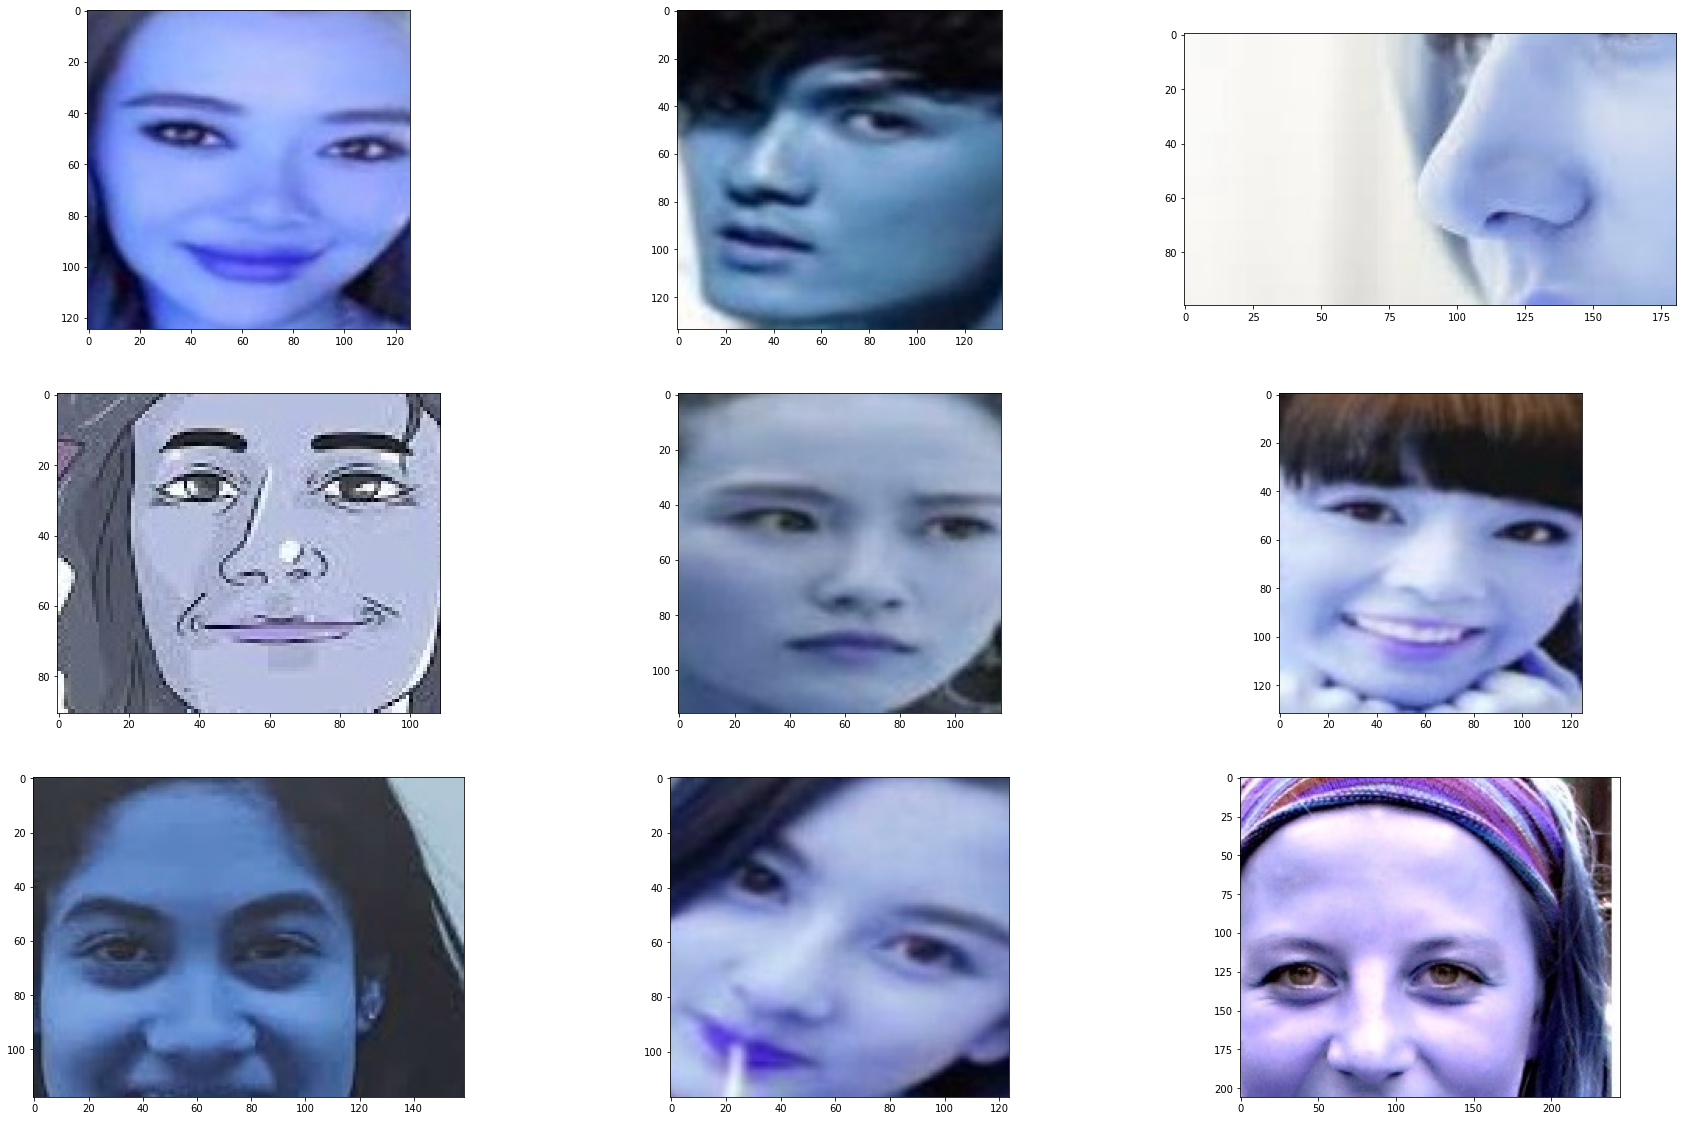

In [24]:
view(NOMASKPATH)

# Analysing our Data

In [25]:
fig = go.Figure(
    data=[go.Pie(labels=['WITHMASK','WITHOUTMASK'], 
        values=[len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))])
    ])
fig.show()

So clearly our Data is not highly imbalanced. So we have good data to work around with

# Splitting Training Test
We have <br>
NO MASK : 667 <br>
WITH MASK : 690 <br>
So now we split data into train test sets. We'll take around 2% data for testing purposes.


In [26]:
os.mkdir(TESTPATH)
os.mkdir(os.path.join(TESTPATH,'with_mask'))
os.mkdir(os.path.join(TESTPATH,'without_mask'))

In [27]:
def getTest(pth):
    dataSplit = int(np.ceil(len(os.listdir(pth))*0.5))
    for img in os.listdir(pth)[-dataSplit:]:
        shutil.move(os.path.join(pth,img), os.path.join('testdata'.join(pth.split('data')),img))
getTest(MASKPATH)
getTest(NOMASKPATH)

In [28]:
len(os.listdir(MASKPATH)),len(os.listdir(NOMASKPATH))

(1502, 2433)

In [29]:
len(os.listdir(os.path.join(TESTPATH,'with_mask'))),len(os.listdir(os.path.join(TESTPATH,'without_mask')))

(1502, 2433)

# Preparing Data Input Pipelines

In [30]:
BATCH_SIZE = 32

In [31]:
trainGen = ImageDataGenerator(
    rescale= 1/255.,
    horizontal_flip=True,
    validation_split = 0.1
)

testGen = ImageDataGenerator(
    rescale= 1/255.,
)

In [32]:
train = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training'
)

validation = trainGen.flow_from_directory(
    DATAPATH, 
    target_size=(224, 224),
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='validation'
)

test = testGen.flow_from_directory(
    TESTPATH, 
    target_size=(224, 224), 
    classes=['with_mask','without_mask'],
    class_mode='categorical', 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

Found 3542 images belonging to 2 classes.
Found 393 images belonging to 2 classes.
Found 3935 images belonging to 2 classes.


# Model Building

In [33]:
mob = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
)
mob.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [34]:
model = Sequential()
model.add(mob)
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['acc'])

In [36]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

In [37]:
with tf.device('/device:GPU:0'):
    hist = model.fit(
        train,
        epochs = 15,
        validation_data = validation,
        callbacks = [checkpoint]
    )

Epoch 1/15
111/111 [==============================] - 999s 9s/step - loss: 0.2999 - acc: 0.8676 - val_loss: 0.2250 - val_acc: 0.9109

Epoch 00001: val_loss improved from inf to 0.22503, saving model to model.h5
Epoch 2/15
111/111 [==============================] - 11s 97ms/step - loss: 0.1768 - acc: 0.9235 - val_loss: 0.1684 - val_acc: 0.9338

Epoch 00002: val_loss improved from 0.22503 to 0.16842, saving model to model.h5
Epoch 3/15
111/111 [==============================] - 11s 98ms/step - loss: 0.1497 - acc: 0.9351 - val_loss: 0.2083 - val_acc: 0.9033

Epoch 00003: val_loss did not improve from 0.16842
Epoch 4/15
111/111 [==============================] - 11s 98ms/step - loss: 0.1265 - acc: 0.9427 - val_loss: 0.1501 - val_acc: 0.9211

Epoch 00004: val_loss improved from 0.16842 to 0.15015, saving model to model.h5
Epoch 5/15
111/111 [==============================] - 11s 99ms/step - loss: 0.1094 - acc: 0.9554 - val_loss: 0.1752 - val_acc: 0.9313

Epoch 00005: val_loss did not improv

In [38]:
model.evaluate(test)

123/123 [==============================] - 903s 7s/step - loss: 0.2954 - acc: 0.9050


[0.2954440414905548, 0.9049555063247681]

In [39]:
model.save('/content/drive/MyDrive/Face Mask/Model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



INFO:tensorflow:Assets written to: /content/drive/MyDrive/Face Mask/Model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Face Mask/Model/assets
